# RFI In Averaged Closure Phase Data

In [1]:
import os
import sys
import h5py
import numpy as np
from scipy import ndimage
from ipywidgets import interact
import matplotlib.pyplot as plt
from matplotlib import colors
from itertools import product
import pywt

sys.path.append("/users/pkeller/code/Wavelets/")

from wavelib import waveflag

## Load Data
This data has been median averaged along the JD axis and coherently averaged across triads and polarisations using inverse variance weights. 

In [2]:
# data directory
ddir = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/"

# triad names
trnames = ["EQ14", "EQ28"]

# field names
fnames = ["A", "B", "C", "D", "E"]

data = dict()

for fname, trname in product(fnames, trnames):
    name = f"{trname}_F{fname}"
    path = os.path.join(ddir, f"{name}_B2_WAVG.h5")
    data.update({name: dict()})
    
    with h5py.File(path, "r") as f:
        freq = f["FRQ"][()]
        data[name].update({"eicp travg": f["eicp travg"][()].T})
        data[name].update({"LST": f["LST"][()]})
        data[name].update({"NLST": np.shape(f["eicp travg"][()])[1]})

## Plot Wavelets
Several wavelets were tested for the following analysis, but the differences are minor. We settled on using a symlet 2 which has 2 vanishing moments while also having minimal support, therefore making it ideal for filtering out narrowband spectral discontinuities. 

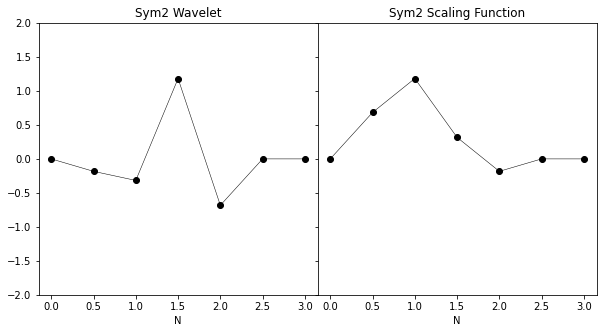

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
sym2 = pywt.Wavelet("sym2")

[phi, psi, x] = sym2.wavefun(1)
ax[0].plot(x, psi, color="k", marker="o", linewidth=0.5)
ax[0].set_title("Sym2 Wavelet")

[phi, psi, x] = sym2.wavefun(1)
ax[1].plot(x, phi, color="k", marker="o", linewidth=0.5)
ax[1].set_title("Sym2 Scaling Function")

fig.subplots_adjust(wspace=0.00, hspace=0.0)

plt.setp(ax, ylim=[-2, 2], xlabel="N");
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/sym2.pdf")

## Discrete Wavelet Transform High Pass

In [4]:
# stack data along temporal axis
data_eq14 = np.vstack([data[dname]["eicp travg"] for dname in data if "EQ14" in dname])
data_eq28 = np.vstack([data[dname]["eicp travg"] for dname in data if "EQ28" in dname])


# LST data
nlst = np.array([data[dname]["NLST"] for dname in data if "EQ14" in dname])
lst = np.hstack([data[dname]["LST"] for dname in data if "EQ14" in dname])

# filter
nlevel = 1
wavelet = "sym2"

data_eq14_hi = np.swapaxes(waveflag.swt_high_pass(data_eq14, wavelet, nlevel=nlevel, pad_width=100), 0, 1)
data_eq28_hi = np.swapaxes(waveflag.swt_high_pass(data_eq28, wavelet, nlevel=nlevel, pad_width=100), 0, 1)

z_eq14 = waveflag.high_pass_z_score(data_eq14, wavelet, nlevel=nlevel, pad_width=100, z_mode="median abs", nan_fill=0)
z_eq28 = waveflag.high_pass_z_score(data_eq28, wavelet, nlevel=nlevel, pad_width=100, z_mode="median abs", nan_fill=0)

/users/pkeller/code/Wavelets/wavelib/waveflag.py:145: RuntimeWarning: invalid value encountered in true_divide
  zsc = dd / sig


## Plot High Pass Filtered Data

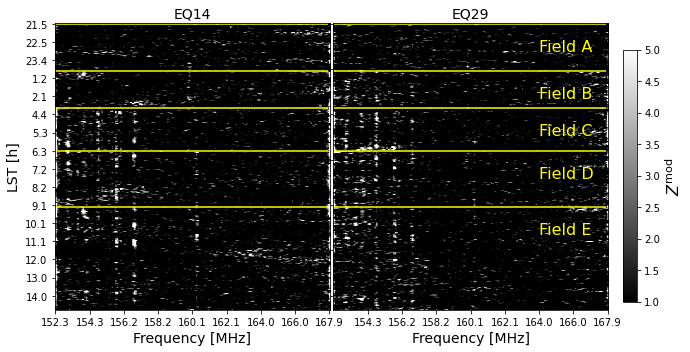

In [5]:
# ticklabels
xticks = np.array(["{:.1f}".format(f) for f in freq])
yticks = np.array(["{:.1f}".format(t) for t in lst])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(z_eq14, aspect="auto", cmap="gray", vmin=1, vmax=5)
im = ax[1].imshow(z_eq28, aspect="auto", cmap="gray", vmin=1, vmax=5)
ax[0].set_xticks(np.arange(0, len(freq), 20))
ax[0].set_yticks(np.arange(0, len(lst), 20))
ax[1].set_xticks(np.arange(20, len(freq), 20))
ax[0].set_yticklabels(yticks[::20])
ax[1].set_yticklabels([])
ax[0].set_xticklabels(xticks[::20])
ax[1].set_xticklabels(xticks[20::20])
ax[0].set_title("EQ14", fontsize=14)
ax[1].set_title("EQ29", fontsize=14)
ax[0].set_xlabel("Frequency [MHz]", fontsize=14)
ax[1].set_xlabel("Frequency [MHz]", fontsize=14)
ax[0].set_ylabel("LST [h]", fontsize=14)

# plot horizontal field separation lines
fields = ["Field A", "Field B", "Field C", "Field D", "Field E"]
for i in range(len(nlst)):
    ax[0].hlines(np.sum(nlst[:i]), 0, 159, color="yellow")
    ax[1].hlines(np.sum(nlst[:i]), 0, 159, color="yellow")
    ax[1].text(120, np.sum(nlst[:i]) + 30, fields[i], color="yellow", fontsize=16)

plt.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.0)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax).set_label(r"$Z^\mathrm{mod}$", size=16)
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/rfi.pdf")

## Average High Pass Data along LST Axis

In [6]:
# weighted average across LST
data_eq14_hi_avg = np.nansum(np.abs(data_eq14_hi) / np.nanmedian(np.abs(data_eq14_hi), axis=0), axis=-1)
data_eq28_hi_avg = np.nansum(np.abs(data_eq28_hi) / np.nanmedian(np.abs(data_eq28_hi), axis=0), axis=-1)

# compute z-score
d_eq14 = data_eq14_hi_avg - np.nanmedian(data_eq14_hi_avg)
d_eq28 = data_eq28_hi_avg - np.nanmedian(data_eq28_hi_avg)
z_avg_eq14 = d_eq14 / (1.4826 * np.nanmedian(np.abs(d_eq14)))
z_avg_eq28 = d_eq28 / (1.4826 * np.nanmedian(np.abs(d_eq28)))

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


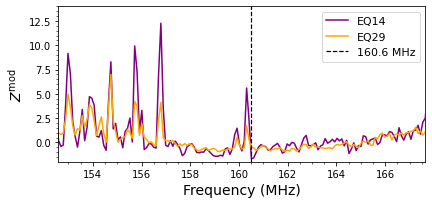

In [8]:
plt.figure(figsize=(6, 3))
plt.plot(freq, z_avg_eq14, color="purple", label="EQ14")
plt.plot(freq, z_avg_eq28, color="orange", label="EQ29")
#plt.vlines(155.23, -2, 14, linestyle="dashed", linewidth=1.2, label="cut 0")
#plt.vlines(157, -2, 14, linestyle="-.", linewidth=1.2,  label="cut 1")
plt.vlines(160.5, -2, 14, linestyle="dashed", linewidth=1.2,  label="160.6 MHz", color="k")
plt.xlim([freq[3], freq[-4]]) # exclude border effects
plt.ylim([-2, 14])
plt.xlabel("Frequency (MHz)", fontsize=14)
plt.ylabel(r"$Z^\mathrm{mod}$", fontsize=14)
plt.minorticks_on()
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/z_score.pdf")

## Plot Closure Phase Spectrogram

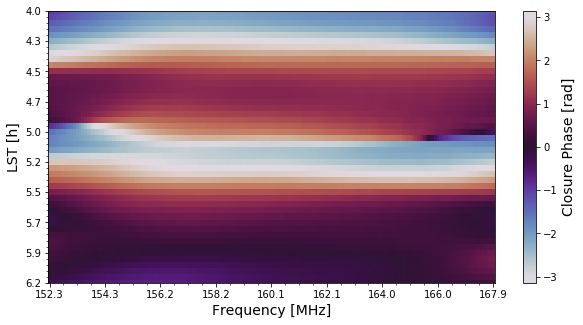

In [8]:
dname = "EQ14_FC"
yticks = np.array(["{:.1f}".format(t) for t in data[dname]["LST"]])

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(np.angle(data["EQ14_FC"]["eicp travg"]), aspect="auto", cmap="twilight", vmin=-np.pi, vmax=np.pi)
ax.set_xlabel("Frequency [MHz]", fontsize=14)
ax.set_ylabel("LST [h]", fontsize=14)
ax.set_xticks(np.arange(0, len(freq), 20))
ax.set_yticks(np.arange(0, len(data[dname]["LST"]), 5))
ax.set_yticklabels(yticks[::5])
ax.set_xticklabels(xticks[::20])
ax.minorticks_on()
fig.colorbar(im).set_label("Closure Phase [rad]", size=14)
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/closure_spec.pdf")

In [10]:
def plot(i):
    fig = plt.figure(figsize=(10, 7))
    plt.scatter(freq, np.angle(data["EQ14_FC"]["eicp travg"][i]), color="k")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Closure Phase [rad]")
    plt.title(f"LST Index {i}")
    plt.minorticks_on()
    plt.show()

interact(plot, i=(0, 46))

interactive(children=(IntSlider(value=23, description='i', max=46), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(i)>